# NBA Game Prediction - Exploratory Data Analysis

Quick EDA to understand our features before modeling with Random Forest/XGBoost.

**Focus areas:**
1. Data quality checks
2. Target distribution (away win rate)
3. Feature distributions
4. Feature-target relationships
5. Temporal patterns

## 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)

print("Libraries loaded!")

Libraries loaded!


In [2]:
# Load the matchup data
df = pd.read_csv('nba_matchups_with_features.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Seasons: {df['season'].min()} - {df['season'].max()}")

Dataset shape: (33204, 118)
Date range: 1996-11-10 to 2025-06-22
Seasons: 1997 - 2025


In [3]:
# Define our feature sets
tier1_features = [
    'pts_L10_diff', 'fg_pct_L10_diff', '3p_pct_L10_diff',
    'opp_pts_L10_diff', 'win_pct_L10_diff', 'plus_minus_L10_diff',
    'rest_advantage', 'is_b2b_home', 'is_b2b_away'
]

tier2_features = [
    'efg_pct_L10_diff', 'ts_pct_L10_diff', '3pa_rate_L10_diff',
    'ast_L10_diff', 'tov_L10_diff', 'reb_L10_diff',
    'stl_L10_diff', 'blk_L10_diff', 'pts_std_L10_diff', 'win_streak_diff'
]

all_features = tier1_features + tier2_features

# Create target: win_away (1 if away team wins, 0 if home team wins)
df['win_away'] = 1 - df['win_home']
target = 'win_away'

print(f"Total features: {len(all_features)}")
print(f"Target variable: {target} (predicting P(away team wins))")

Total features: 19
Target variable: win_away (predicting P(away team wins))


## 2. Data Quality Checks

In [4]:
# Missing values
missing = df[all_features + [target]].isnull().sum()
if missing.sum() > 0:
    print("Missing values:")
    print(missing[missing > 0])
else:
    print("✓ No missing values in features or target")

✓ No missing values in features or target


In [5]:
# Basic statistics
print("Feature summary statistics:")
df[all_features].describe().round(2)

Feature summary statistics:


,pts_L10_diff,fg_pct_L10_diff,3p_pct_L10_diff,opp_pts_L10_diff,win_pct_L10_diff,plus_minus_L10_diff,rest_advantage,is_b2b_home,is_b2b_away,efg_pct_L10_diff,ts_pct_L10_diff,3pa_rate_L10_diff,ast_L10_diff,tov_L10_diff,reb_L10_diff,stl_L10_diff,blk_L10_diff,pts_std_L10_diff,win_streak_diff
count,33204.00,33204.00,33204.00,33204.00,33204.0,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00
mean,-0.12,-0.02,-0.00,0.03,-0.0,-0.15,0.23,0.14,0.27,-0.00,-0.00,0.00,-0.05,0.00,-0.07,-0.01,-0.02,-0.00,-0.08
std,7.75,3.14,5.54,7.82,0.3,8.71,1.56,0.35,0.45,0.04,0.04,0.07,3.40,2.25,3.77,1.75,1.59,3.84,4.74
min,-31.00,-11.71,-22.75,-30.60,-1.0,-38.90,-11.00,0.00,0.00,-0.16,-0.14,-0.28,-13.10,-8.60,-15.40,-6.90,-7.30,-16.23,-32.00
25%,-5.30,-2.13,-3.61,-5.30,-0.2,-6.02,0.00,0.00,0.00,-0.03,-0.02,-0.05,-2.30,-1.50,-2.60,-1.20,-1.10,-2.56,-3.00
50%,-0.10,-0.02,-0.04,0.00,0.0,-0.20,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.10,0.00,-0.10,0.00,0.00,0.01,0.00
75%,5.10,2.08,3.53,5.30,0.2,5.70,1.00,0.00,1.00,0.02,0.02,0.05,2.20,1.50,2.50,1.20,1.00,2.58,3.00
max,32.10,13.04,26.20,30.00,1.0,33.90,144.00,1.00,1.00,0.13,0.15,0.27,14.00,10.20,15.80,7.50,7.40,18.38,37.00


## 3. Target Distribution

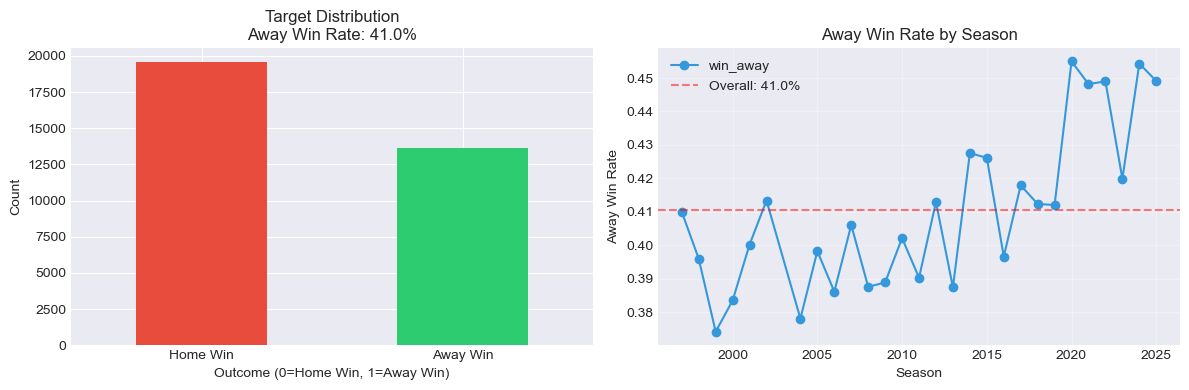


✓ Home court advantage (disadvantage for away team): 9.0 percentage points


In [6]:
# Away win rate
away_win_rate = df[target].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
df[target].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title(f'Target Distribution\nAway Win Rate: {away_win_rate:.1%}', fontsize=12)
axes[0].set_xlabel('Outcome (0=Home Win, 1=Away Win)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Home Win', 'Away Win'], rotation=0)

# Over time
away_win_by_season = df.groupby('season')[target].mean()
away_win_by_season.plot(ax=axes[1], marker='o', color='#3498db')
axes[1].axhline(away_win_rate, color='red', linestyle='--', alpha=0.5, label=f'Overall: {away_win_rate:.1%}')
axes[1].set_title('Away Win Rate by Season', fontsize=12)
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Away Win Rate')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Home court advantage (disadvantage for away team): {(0.5 - away_win_rate) * 100:.1f} percentage points")

## 4. Feature Distributions

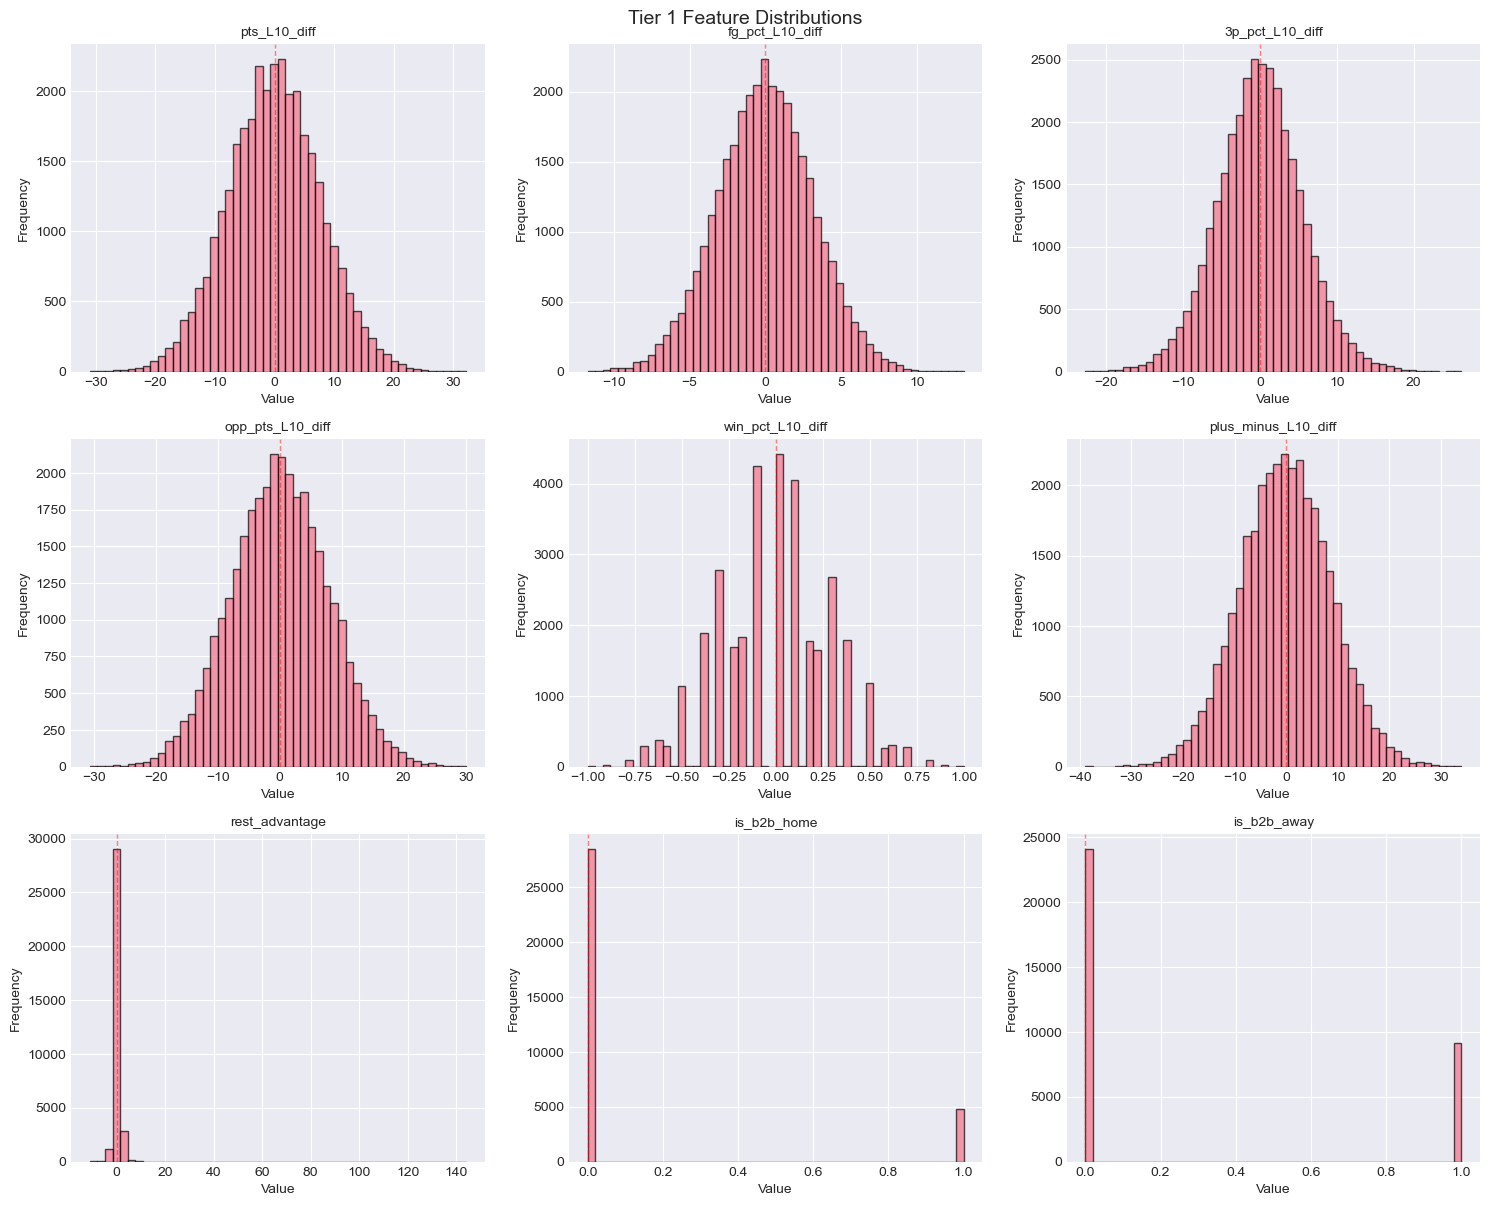

In [7]:
# Distribution of key Tier 1 features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(tier1_features):
    axes[i].hist(df[feature].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[i].set_title(feature, fontsize=10)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Tier 1 Feature Distributions', fontsize=14, y=1.001)
plt.show()

## 5. Feature-Target Relationships

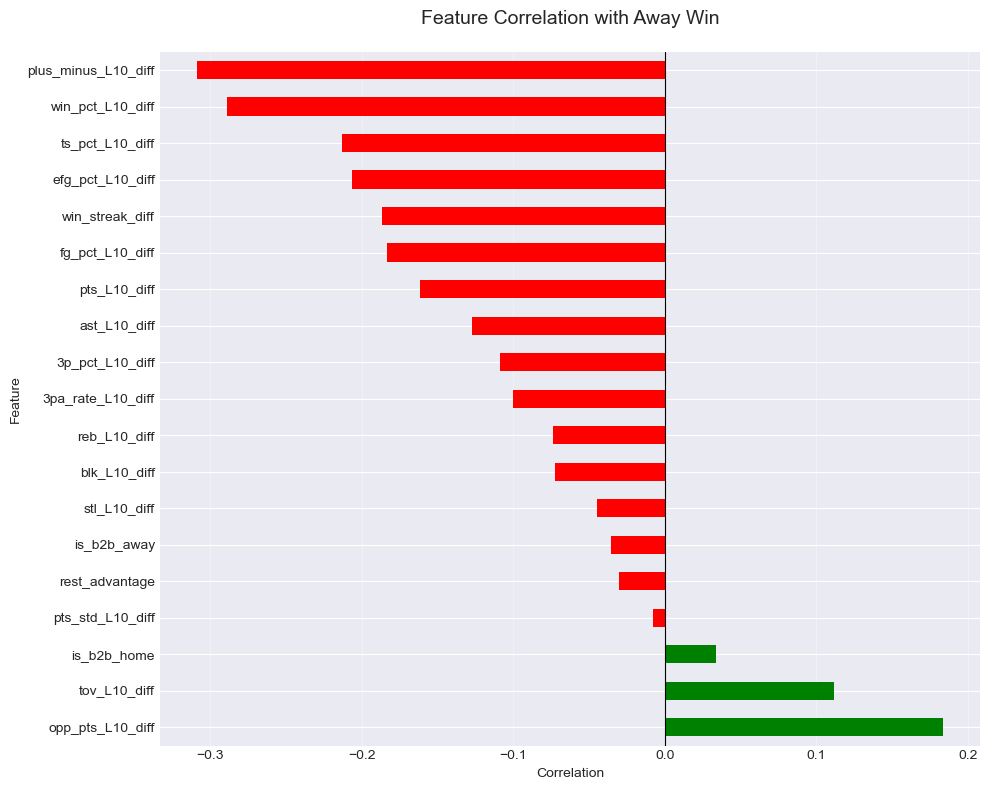


Top 5 most correlated features:
opp_pts_L10_diff    0.183226
tov_L10_diff        0.111641
is_b2b_home         0.034028
pts_std_L10_diff   -0.007781
rest_advantage     -0.030259
dtype: float64


In [8]:
# Correlation with target
correlations = df[all_features].corrwith(df[target]).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations])
plt.title('Feature Correlation with Away Win', fontsize=14, pad=20)
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 most correlated features:")
print(correlations.head())

/var/folders/06/ch9jy96s5t9g6b33_x_246b00000gn/T/ipykernel_11574/805571238.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_q = df.groupby('quartile')[target].mean()
/var/folders/06/ch9jy96s5t9g6b33_x_246b00000gn/T/ipykernel_11574/805571238.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_q = df.groupby('quartile')[target].mean()
/var/folders/06/ch9jy96s5t9g6b33_x_246b00000gn/T/ipykernel_11574/805571238.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or ob

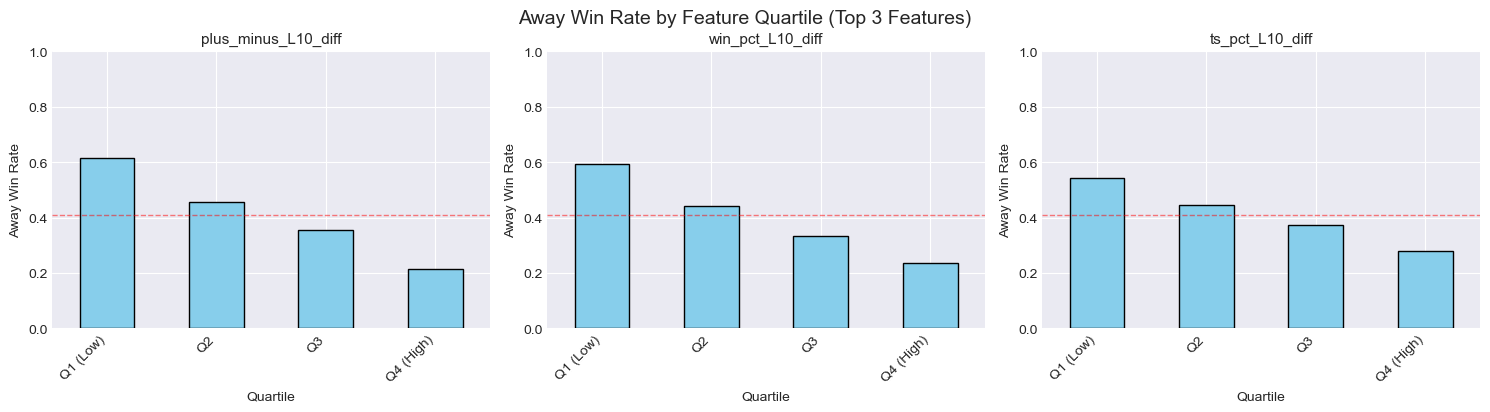

In [9]:
# Win rate by feature quartiles (top 3 features)
top_features = correlations.abs().nlargest(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(top_features):
    # Create quartiles
    df['quartile'] = pd.qcut(df[feature], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], duplicates='drop')
    
    # Calculate win rate by quartile
    win_rate_by_q = df.groupby('quartile')[target].mean()
    
    win_rate_by_q.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feature}', fontsize=11)
    axes[i].set_ylabel('Away Win Rate')
    axes[i].set_xlabel('Quartile')
    axes[i].axhline(away_win_rate, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Away Win Rate by Feature Quartile (Top 3 Features)', fontsize=14, y=1.02)
plt.show()

df.drop('quartile', axis=1, inplace=True)

## 6. Feature Relationships (Multicollinearity Check)

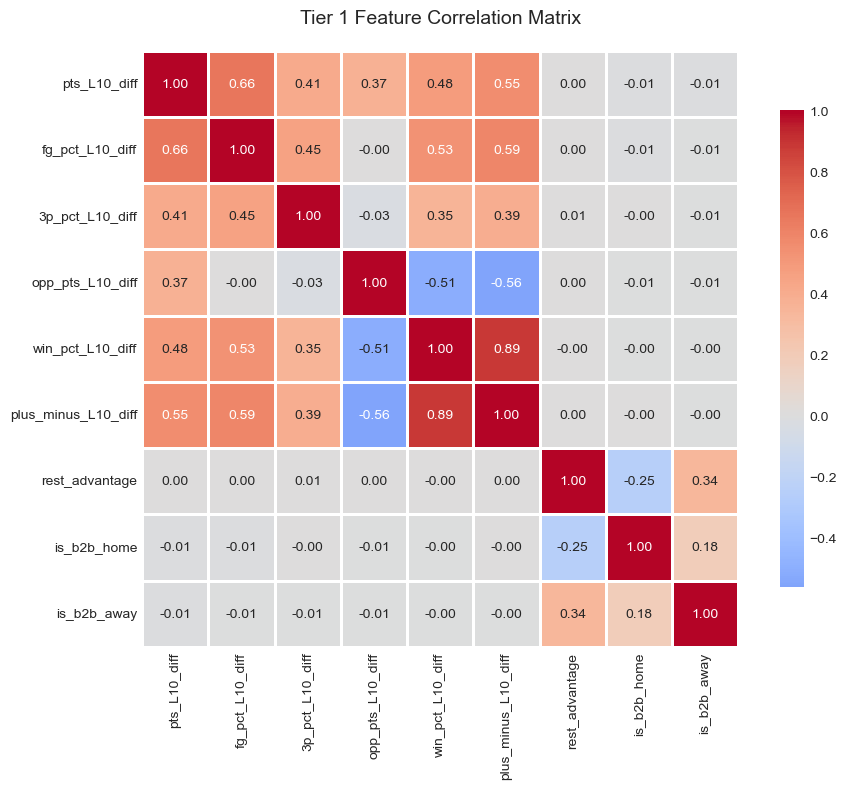


Highly correlated feature pairs (|r| > 0.7):
  win_pct_L10_diff <-> plus_minus_L10_diff: 0.885


In [10]:
# Correlation matrix for Tier 1 features
corr_matrix = df[tier1_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Tier 1 Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("\nHighly correlated feature pairs (|r| > 0.7):")
    for f1, f2, corr in high_corr:
        print(f"  {f1} <-> {f2}: {corr:.3f}")
else:
    print("\n✓ No highly correlated feature pairs (good for interpretability)")

## 7. Temporal Patterns

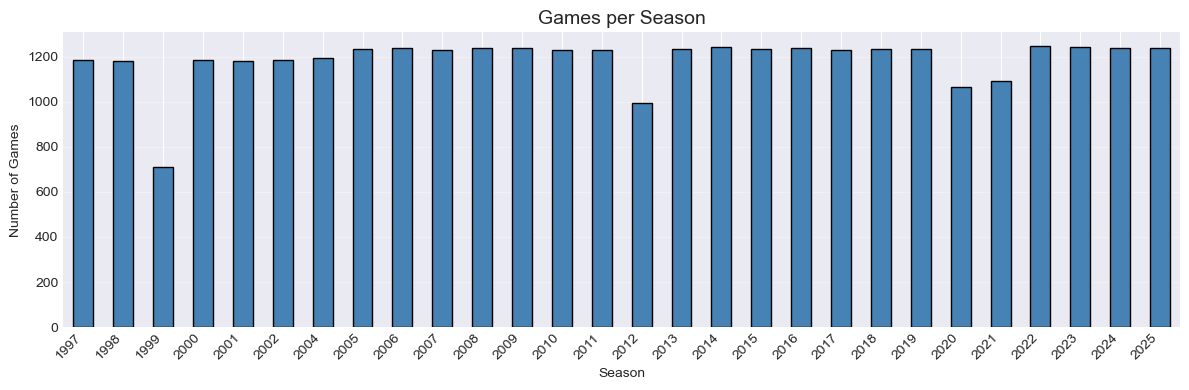

Average games per season: 1186
Min: 711 (1999)
Max: 1245 (2022)


In [11]:
# Games per season
games_per_season = df.groupby('season').size()

plt.figure(figsize=(12, 4))
games_per_season.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Games per Season', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Average games per season: {games_per_season.mean():.0f}")
print(f"Min: {games_per_season.min()} ({games_per_season.idxmin()})")
print(f"Max: {games_per_season.max()} ({games_per_season.idxmax()})")

## 8. Train/Val/Test Split Preview

In [12]:
# Time-based splits for modeling
train = df[df['season'] <= 2021]
val = df[(df['season'] >= 2022) & (df['season'] <= 2023)]
test = df[df['season'] >= 2024]

print("Recommended time-based splits:")
print(f"\nTraining (≤2021):   {len(train):,} games ({len(train)/len(df)*100:.1f}%)")
print(f"Validation (2022-23): {len(val):,} games ({len(val)/len(df)*100:.1f}%)")
print(f"Test (≥2024):        {len(test):,} games ({len(test)/len(df)*100:.1f}%)")
print(f"\nTotal:               {len(df):,} games")

# Away win rates by split
print("\nAway win rates:")
print(f"  Training:   {train[target].mean():.1%}")
print(f"  Validation: {val[target].mean():.1%}")
print(f"  Test:       {test[target].mean():.1%}")

Recommended time-based splits:

Training (≤2021):   28,243 games (85.1%)
Validation (2022-23): 2,486 games (7.5%)
Test (≥2024):        2,475 games (7.5%)

Total:               33,204 games

Away win rates:
  Training:   40.5%
  Validation: 43.4%
  Test:       45.2%


## Summary

**Key Findings:**
1. ✓ No missing values in features
2. ✓ ~41% away win rate (strong home court advantage impacts away teams)
3. ✓ Features show expected relationships with target
4. ✓ Data quality looks good across all seasons
5. ✓ Ready for Random Forest/XGBoost modeling

**Next Steps:**
- Train baseline Random Forest model
- Try XGBoost for comparison
- Tune hyperparameters
- Calibrate probabilities
- Evaluate on test set